# SDSL Site Screen

In [1]:
from itertools import combinations
import numpy as np
from scipy.stats import wasserstein_distance
import chilife as xl

r = np.linspace(0, 100, 256)

unbound = xl.fetch('1omp')
bound = xl.fetch('1anf')

# Get residues that are solvent accessible in both conformations
unbound_SASR = xl.get_sas_res(unbound, 50)
bound_SASR = xl.get_sas_res(bound, 50)
SASR = unbound_SASR & bound_SASR

Ps, SL_pairs = [], []
for protein in (unbound, bound):

    # Create SpinLabels at shared solvent accessible sites
    SLs = {site: xl.SpinLabel('R1M', site, protein, chain=chain) 
                for site, chain in SASR}

    # Calculate distance distributions between all pairs
    pairs = list(combinations(SLs.values(), r=2))
    SL_pairs.append(pairs)
    Ps.append(np.array([xl.distance_distribution(SL1, SL2, r) for SL1, SL2 in pairs]))

EMDs = [wasserstein_distance(r, r, P_unbound, P_bound) for P_unbound, P_bound in zip(*Ps)]
arg = np.argmax(EMDs)

unbound_SL1, unbound_SL2 = SL_pairs[0][arg]
bound_SL1, bound_SL2 = SL_pairs[1][arg]

unbound_P = Ps[0][arg]
bound_P = Ps[1][arg]

C:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Program Files\Python310\lib\site-packages\memoization\memoization.py:112: SyntaxWarning: Expected custom_key_maker to have the same signature as the function being cached. Call memoization.suppress_warnings() before using @cached to remove this message.
  warnings.warn('Expected custom_key_maker to have the same signature as the function being cached. '


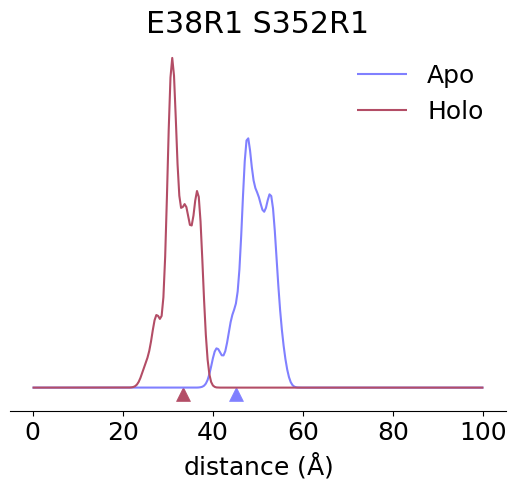

In [2]:

import matplotlib.pyplot as plt

arg = np.argmax(EMDs)

unbound_SL1, unbound_SL2 = SL_pairs[0][arg]
bound_SL1, bound_SL2 = SL_pairs[1][arg]

unbound_P = Ps[0][arg]
bound_P = Ps[1][arg]

omp_cbd = np.linalg.norm(unbound_SL1.coords[0, unbound_SL1.atom_names=='CB'] - unbound_SL2.coords[0, unbound_SL2.atom_names=='CB'])
anf_cbd = np.linalg.norm(bound_SL1.coords[0, bound_SL1.atom_names=='CB'] - bound_SL2.coords[0, bound_SL2.atom_names=='CB'])

plt.style.use('chiLife')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots()
ax.set_title(f'{bound_SL1.nataa}{bound_SL1.site}R1 {bound_SL2.nataa}{bound_SL2.site}R1')

ax.plot(r, unbound_P, label='Apo')
ax.plot(r, bound_P, label='Holo')


ax.scatter(omp_cbd,-0.003, color='C0', marker='^', s=100)
ax.scatter(anf_cbd,-0.003, color='C1', marker='^', s=100)

ax.set_yticks([])
ax.set_xlabel(r'distance ($\rm\AA$)')
ax.legend(frameon=False)

for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()
fig.savefig(f'{bound_SL1.nataa}{bound_SL1.site}R1 {bound_SL2.nataa}{bound_SL2.site}R1 Pr.png', bbox_inches='tight', dpi=1000)
xl.save('omp_S1.pdb', *SL_pairs[0][arg], unbound)
xl.save('anf_S1.pdb', *SL_pairs[1][arg], bound)

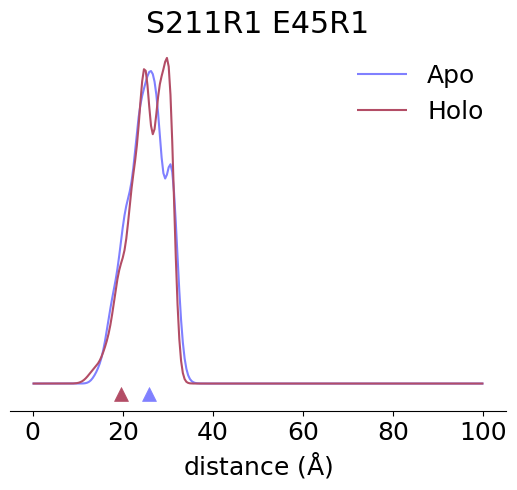

In [3]:
pair = (211, 45)
unbound_SL1, unbound_SL2 = [xl.SpinLabel('R1M', x, unbound) for x in pair]
bound_SL1, bound_SL2 = [xl.SpinLabel('R1M', x, bound) for x in pair]

unbound_P = xl.distance_distribution(unbound_SL1, unbound_SL2, r)
bound_P = xl.distance_distribution(bound_SL1, bound_SL2, r)

omp_cbd = np.linalg.norm(unbound_SL1.coords[0, unbound_SL1.atom_names=='CB'] - unbound_SL2.coords[0, unbound_SL2.atom_names=='CB'])
anf_cbd = np.linalg.norm(bound_SL1.coords[0, bound_SL1.atom_names=='CB'] - bound_SL2.coords[0, bound_SL2.atom_names=='CB'])

fig, ax = plt.subplots()
ax.set_title(f'{bound_SL1.nataa}{bound_SL1.site}R1 {bound_SL2.nataa}{bound_SL2.site}R1')

ax.plot(r, unbound_P, label='Apo')
ax.plot(r, bound_P, label='Holo')


ax.scatter(omp_cbd,-0.003, color='C0', marker='^', s=100)
ax.scatter(anf_cbd,-0.003, color='C1', marker='^', s=100)

ax.set_yticks([])
ax.set_xlabel(r'distance ($\rm\AA$)')
ax.legend(frameon=False)

for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()
fig.savefig(f'{bound_SL1.nataa}{bound_SL1.site}R1 {bound_SL2.nataa}{bound_SL2.site}R1 Pr.png', bbox_inches='tight', dpi=1000)
xl.save('omp_S2.pdb', unbound_SL1, unbound_SL2, unbound)
xl.save('anf_S2.pdb', bound_SL1, bound_SL2, bound)

In [4]:
nres = len(bound.select_atoms('protein').residues)
EMD_Matrix = np.zeros((nres, nres))

for emd, (SL1, SL2) in zip(EMDs, SL_pairs[0]):
    idx1, idx2 = SL1.site - 1, SL2.site - 1
    EMD_Matrix[idx1, idx2] = emd
    EMD_Matrix[idx2, idx1] = emd
    

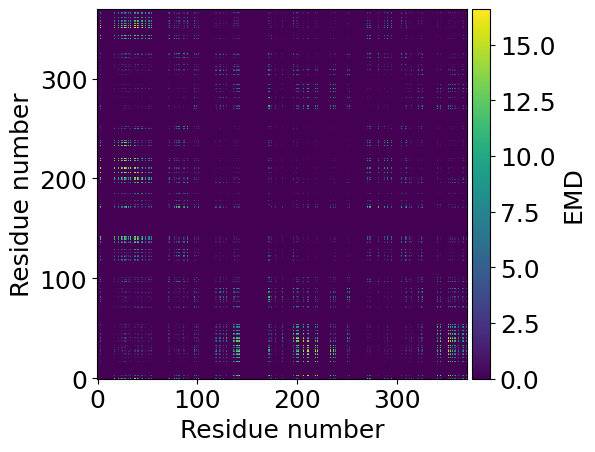

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
im = ax.imshow(EMD_Matrix, origin='lower')

ax.set_xlabel('Residue number')
ax.set_ylabel('Residue number')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cax = plt.colorbar(im, cax=cax)
cax.set_label('EMD')
plt.show()

